##### **Jon Sedar Personal Project**

### PyMC3 Examples `pymc3_examples`

###### _2019Q4_

# GLM: Robust Regression using a Gaussian Mixture Model for Outlier Classification

`glm-robust-regression-using-a-gaussian-mixture-model-for-outlier-classification.ipynb`

Using PyMC3 for Robust Regression with Outlier Detection using a (non-marginalized) mixture model. To be compared with the Hogg 2010 Signal vs Noise method demonstrated in [a sister Notebook](glm-robust-regression-using-custom-likelihood-for-outlier-classification). 

+ This uses a mixture model of two Gaussian (Normal) data-generating functions: one for inliers conditioned on x and one for outliers.
+ The mixture model is not marginalized because we want to classify each datapoint (aka it's a latent variable model)
+ The dataset is tiny and hardcoded into this Notebook. It contains errors in both the x and y, but we will deal here with only errors in y.


## Contents

+ [Setup](#Setup)
    + [Installation Notes](#Installation-Notes)
    + [Imports](#Imports)
    + [Local Functions](#Local-Functions)
    + [Load Data](#Load-Data)
+ [1. Basic EDA](#1.-Basic-EDA)
+ [2. Basic Feature Engineering](#2.-Basic-Feature-Engineering)
+ [3. Gaussian Mixture Model: Marginalized](#3.-Gaussian-Mixture-Model:-Marginalized)
+ [4. Gaussian Mixture Model: Non-Marginalized](#3.-Gaussian-Mixture-Model:-Non-Marginalized)

# Setup

## Installation Notes

See the project [README](https://github.com/jonsedar/pymc3_examples/blob/master/README.md) for full details. For MVP reproduction, see following notes

##### General:

+ This is a Python 3.6 project using latest available [PyMC3](https://github.com/pymc-devs/pymc3) at time of writing `pymc3=3.7`
+ Developed in 2019Q4 using [ContinuumIO Anaconda](https://www.continuum.io/downloads) distribution on a Macbook 2017 1.4GHz i7 Dual Core, 16GB RAM, OSX 10.14.6
+ If runs become unstable or Theano throws weird errors, first try clearing the cache `theano-cache clear` and rerunning the notebook.


##### Package Requirements (shown as a condaenv YAML)

```
$> less conda_env_pymc3_examples.yml

    name: pymc3_examples
    channels:
    - defaults
    - conda-forge
    dependencies:
    - python==3.6.*
    - cython
    - ipython
    - jupyter
    - mkl
    - mkl-service
    - numpy
    - scipy
    - matplotlib
    - pandas
    - scikit-learn
    - seaborn
    - patsy
    - statsmodels
    - tqdm
    - watermark
    - sphinx
    - pytest
    - nose
    - parameterized
    - python-graphviz
    - pip

$> conda env create --file conda_env_pymc3_examples.yml
$> source activate pymc3_examples
$> pip install pymc3==3.7 theano arviz daft
$> jupyter notebook
```

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%qtconsole --style=monokai --ConsoleWidget.font_size=11

## Imports

In [2]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import pymc3 as pm
import arviz as az
import theano.tensor as tt

# terrible practice, but hiding for presentation after notebook development
import warnings
warnings.filterwarnings('ignore')  

sns.set(style='darkgrid', palette='muted', context='notebook')
plt.rcParams['figure.figsize'] = 16, 4
np.random.seed(0)

%load_ext watermark
%watermark -dtmvgp numpy,scipy,matplotlib,pandas,seaborn,pymc3,theano,arviz

2019-11-03 20:40:25 

CPython 3.6.9
IPython 7.8.0

numpy 1.17.2
scipy 1.3.1
matplotlib 3.1.1
pandas 0.25.2
seaborn 0.9.0
pymc3 3.7
theano 1.0.4
arviz 0.5.1

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 18.7.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
Git hash   : 8f4b91a35b07afdb17915b4f2b7f383fd4b053db


## Local Functions

In [3]:
# None

## Load Data

We'll use the Hogg 2010 data available at  https://github.com/astroML/astroML/blob/master/astroML/datasets/hogg2010test.py

It's a very small dataset so for convenience, it's hardcoded below

In [4]:
# cut & pasted directly from the fetch_hogg2010test() function
# identical to the original dataset as hardcoded in the Hogg 2010 paper

dfhogg = pd.DataFrame(np.array([[1, 201, 592, 61, 9, -0.84],
                                 [2, 244, 401, 25, 4, 0.31],
                                 [3, 47, 583, 38, 11, 0.64],
                                 [4, 287, 402, 15, 7, -0.27],
                                 [5, 203, 495, 21, 5, -0.33],
                                 [6, 58, 173, 15, 9, 0.67],
                                 [7, 210, 479, 27, 4, -0.02],
                                 [8, 202, 504, 14, 4, -0.05],
                                 [9, 198, 510, 30, 11, -0.84],
                                 [10, 158, 416, 16, 7, -0.69],
                                 [11, 165, 393, 14, 5, 0.30],
                                 [12, 201, 442, 25, 5, -0.46],
                                 [13, 157, 317, 52, 5, -0.03],
                                 [14, 131, 311, 16, 6, 0.50],
                                 [15, 166, 400, 34, 6, 0.73],
                                 [16, 160, 337, 31, 5, -0.52],
                                 [17, 186, 423, 42, 9, 0.90],
                                 [18, 125, 334, 26, 8, 0.40],
                                 [19, 218, 533, 16, 6, -0.78],
                                 [20, 146, 344, 22, 5, -0.56]]),
                   columns=['id','x','y','sigma_y','sigma_x','rho_xy'])

# for convenience zero-base the 'id' and use as index
dfhogg['id'] = (dfhogg['id'] - 1).apply(lambda x: 'p{}'.format(int(x)))
dfhogg.set_index('id', inplace=True)
dfhogg.head()

,x,y,sigma_y,sigma_x,rho_xy
id,,,,,
p0,201.0,592.0,61.0,9.0,-0.84
p1,244.0,401.0,25.0,4.0,0.31
p2,47.0,583.0,38.0,11.0,0.64
p3,287.0,402.0,15.0,7.0,-0.27
p4,203.0,495.0,21.0,5.0,-0.33


---

# 1. Basic EDA

##### Exploratory Data Analysis

Note:
+ this is very rudimentary so we can quickly get to the `pymc3`
+ the dataset contains errors in both the x and y, but we will deal here with only errors in y.
+ see the [Hogg 2010 paper](https://arxiv.org/pdf/1008.4686.pdf) for more detail

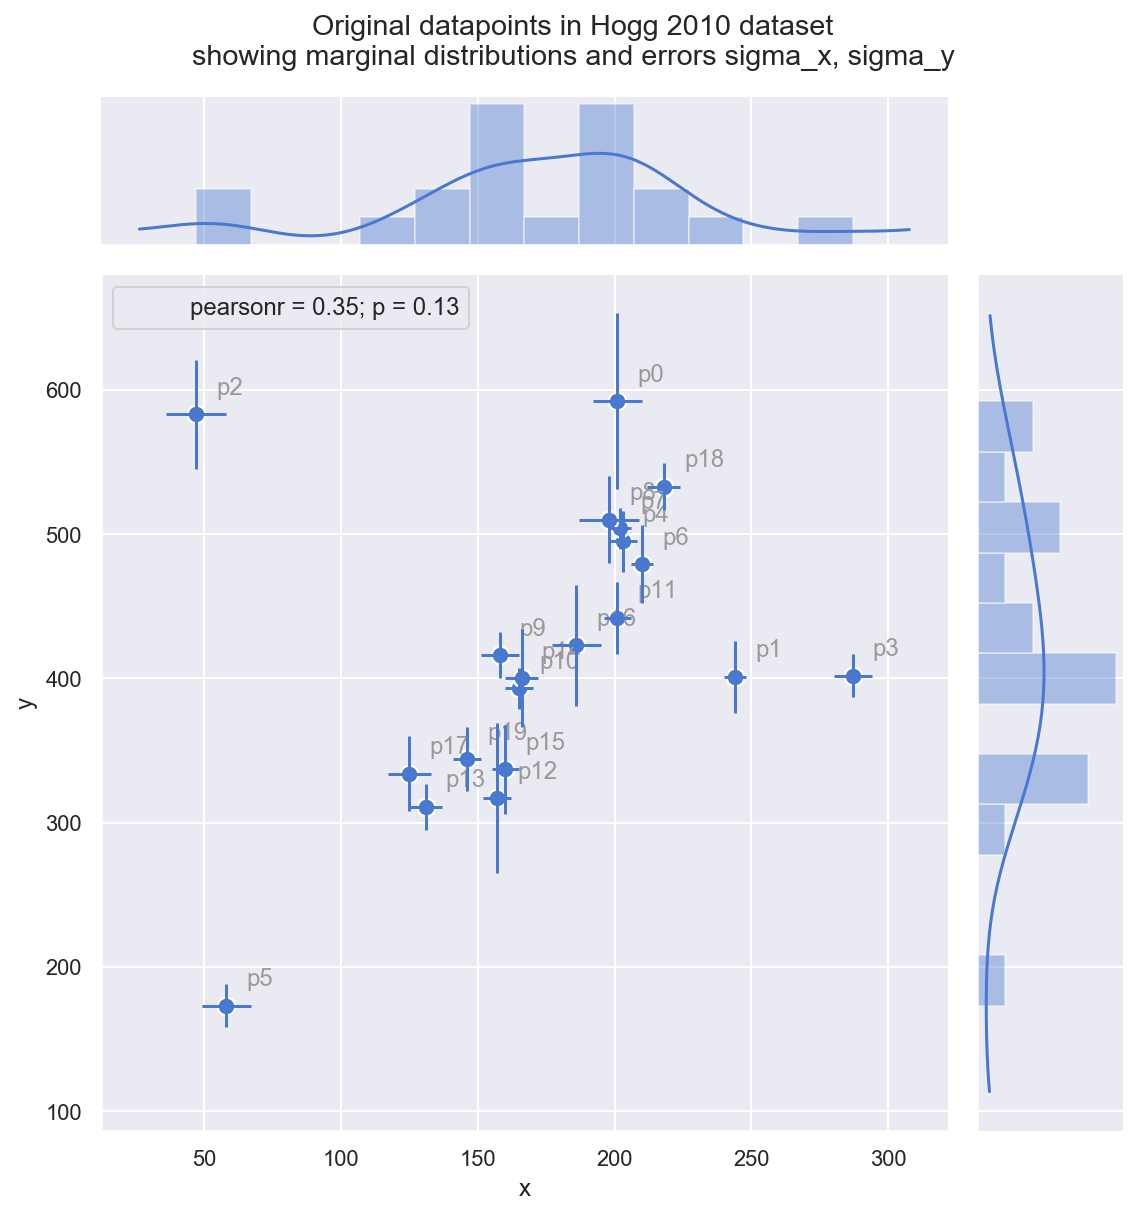

In [5]:
gd = sns.jointplot(x='x', y='y', data=dfhogg, kind='scatter', height=8,
        marginal_kws={'bins':12, 'kde':True, 'kde_kws':{'cut':1}},
        joint_kws={'edgecolor':'w', 'linewidth':1.2, 's':80})

_ = gd.ax_joint.errorbar('x', 'y', 'sigma_y', 'sigma_x', fmt='none', 
                            ecolor='#4878d0', data=dfhogg, zorder=10)
for idx, r in dfhogg.iterrows():
    _ = gd.ax_joint.annotate(s=idx, xy=(r['x'], r['y']), xycoords='data', 
                             xytext=(10, 10), textcoords='offset points', color='#999999', zorder=1)
    
_ = gd.annotate(stats.pearsonr, loc="upper left", fontsize=12)
_ = gd.fig.suptitle(('Original datapoints in Hogg 2010 dataset\n' + 
        'showing marginal distributions and errors sigma_x, sigma_y'), y=1.05)

**Observe**:  

+ Even judging just by eye, you can see these observations mostly fall on / around a straight line with positive gradient
+ It looks like a few of the datapoints may be outliers from such a line
+ Measurement error (independently on x and y) varies across the observations

---

# 2. Basic Feature Engineering

Note: ordinarily I might run through more formalised steps to split into Train and Test sets (to later help evaluate model fit), but here I'll just fit the model to the full dataset and stop at inference

## 2.1 Transform and standardize dataset

It's common practice to standardize the input values to a linear model, because this leads to coefficients sitting in the same range and beng more directly comparable. e.g. Gelman notes this in a 2007 paper: http://www.stat.columbia.edu/~gelman/research/published/standardizing7.pdf.

So, following Gelman's paper above, we'll divide by 2 s.d. here
+ since this model is very simple, we just standardize directly, rather than using e.g. a scikit-learn FunctionTransformer
+ ignoring `rho_xy` for now

**Additional note** on scaling the output feature `y` and measurement error `sigma_y`:
+ This is unconventional - typically you wouldn't scale an output feature
+ However, in the Hogg model we fit a custom two-part likelihood function of Normals which encourages a globally minimised log-loss by allowing outliers to fit to their own Normal distribution. This outlier distribution is specified using a stdev stated as an offset `sigma_y_out` from `sigma_y`
+ This offset value has the effect of requiring `sigma_y` to be restated in the same scale as the stdev of `y`

### Standardize (mean center and divide by 2 sd)

In [6]:
dfhoggs = (dfhogg[['x', 'y']] - dfhogg[['x', 'y']].mean(0)) / (2 * dfhogg[['x', 'y']].std(0))
dfhoggs['sigma_x'] = dfhogg['sigma_x'] / ( 2 * dfhogg['x'].std())
dfhoggs['sigma_y'] = dfhogg['sigma_y'] / ( 2 * dfhogg['y'].std())

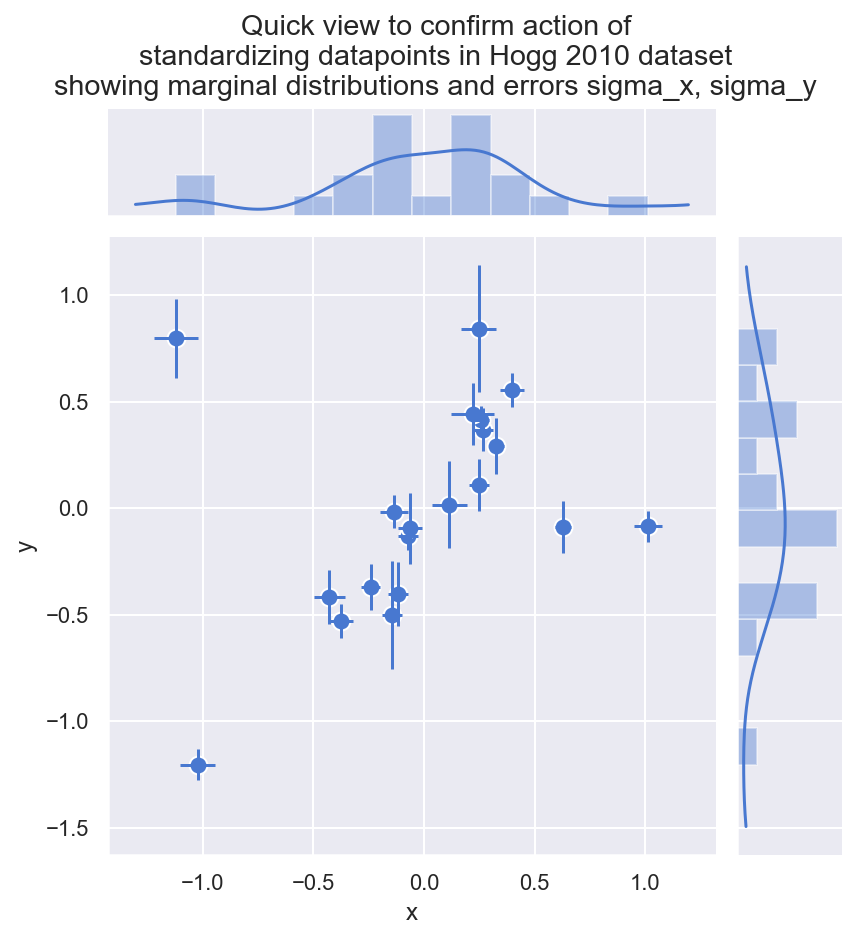

In [7]:
gd = sns.jointplot(x='x', y='y', data=dfhoggs, kind='scatter', height=6,
        marginal_kws={'bins':12, 'kde':True, 'kde_kws':{'cut':1}},
        joint_kws={'edgecolor':'w', 'linewidth':1, 's':80})
_ = gd.ax_joint.errorbar('x', 'y', 'sigma_y', 'sigma_x', fmt='none', 
                            ecolor='#4878d0', data=dfhoggs)
_ = gd.fig.suptitle(('Quick view to confirm action of\n' +
        'standardizing datapoints in Hogg 2010 dataset\n' + 
        'showing marginal distributions and errors sigma_x, sigma_y'), y=1.08)

---

# 3. Gaussian Mixture Model: Marginalized

Before we non-marginalize, let's marginalize over $\eta$: the model ought to run faster and be simpler to specify

## 3.1 Specify Model

Blurb WIP

\begin{align}
\mu_{k} &\sim \mathcal{N}(0, 1)\\
\sigma_{k} &\sim \text{HalfCauchy}(10)\\
\\
\vec{\alpha} &\sim [1]^K\\
\vec{w} &\sim \text{Dir}(\vec{\alpha})\\
\\
\mathcal{f}(x | \vec{w}) &= \sum^{K}_{k=1}w_{k}\mathcal{N}(x | \mu_{k}, \sigma_{k})\\
\end{align}

... where:
+ $k \in K$ total Gaussian mixtures (here $K = 2$: one for inliers, one for outliers)


```python
# + $\beta$ = $\{1, \beta_{j \in X_{j}}\}$  <-- linear coefs in $X_{j}$, in this case `1 + x`
# + $\sigma$ = measurement error on the y axis <-- in this case we set this to the measured error `sigma_y`

# Note: the dataset also has `sigma_x` and `rho_xy` available, but for this exercise, I've chosen to only use `sigma_y`
```

In [96]:
eta = ['inlier', 'outlier']
K = len(eta)

with pm.Model() as mdl_mix_marg:
    
    # input data as Theano shared vars
    tsv_x = pm.Data('tsv_x', np.concatenate(
                                (dfhoggs['x'].values.reshape(-1, 1), 
                                 np.zeros((len(a), 1))), axis=1))     # (n, K)
    tsv_y = pm.Data('tsv_y', dfhoggs['y'])                            # (n, )
    
    # priors on intercept and slope (L2 ridge reg)
    b0 = pm.Normal('b0', mu=0, sigma=10, shape=(K,), 
                   testval=([pm.floatX(tsv_y.eval().mean())]*K))      # (K, )
    b1 = pm.Normal('b1', mu=0, sigma=10, shape=(K,))                  # (K, ) 
        
    # noise
    sigma = pm.HalfCauchy('sigma', beta=10, shape=(K,))               # (K, )
    
    mu = b0 + b1 * tsv_x                                              # (n, K)

    # break symmetry
    potential = pm.Potential('order', tt.switch(mu[1] - mu[0] < 0, -1e15, 0)) 

    # weakly informative prior on mixture weights
    w0 = pm.Dirichlet('w0', a=np.ones(K), testval=np.ones(K)/K)       # (K, )

    likelihood = pm.NormalMixture('likelihood', w=w0, mu=mu, 
                                  sigma=sigma, observed=tsv_y)


## 3.2 Fit Model

### 3.2.1 Sample Posterior

In [106]:
with mdl_mix_marg:
    trc_mix_marg = pm.sample(tune=1000, draws=500, chains=6, cores=3, 
                    init='jitter+adapt_diag', progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 3 jobs)
NUTS: [w0, sigma, b1, b0]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:16<00:00, 355.42draws/s]
There were 273 divergences after tuning. Increase `target_accept` or reparameterize.
There were 304 divergences after tuning. Increase `target_accept` or reparameterize.
There were 267 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.05500449889089613, but should be close to 0.8. Try to increase the number of tuning steps.
There were 303 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


### 3.2.2 View Diagnostics

##### Traceplot

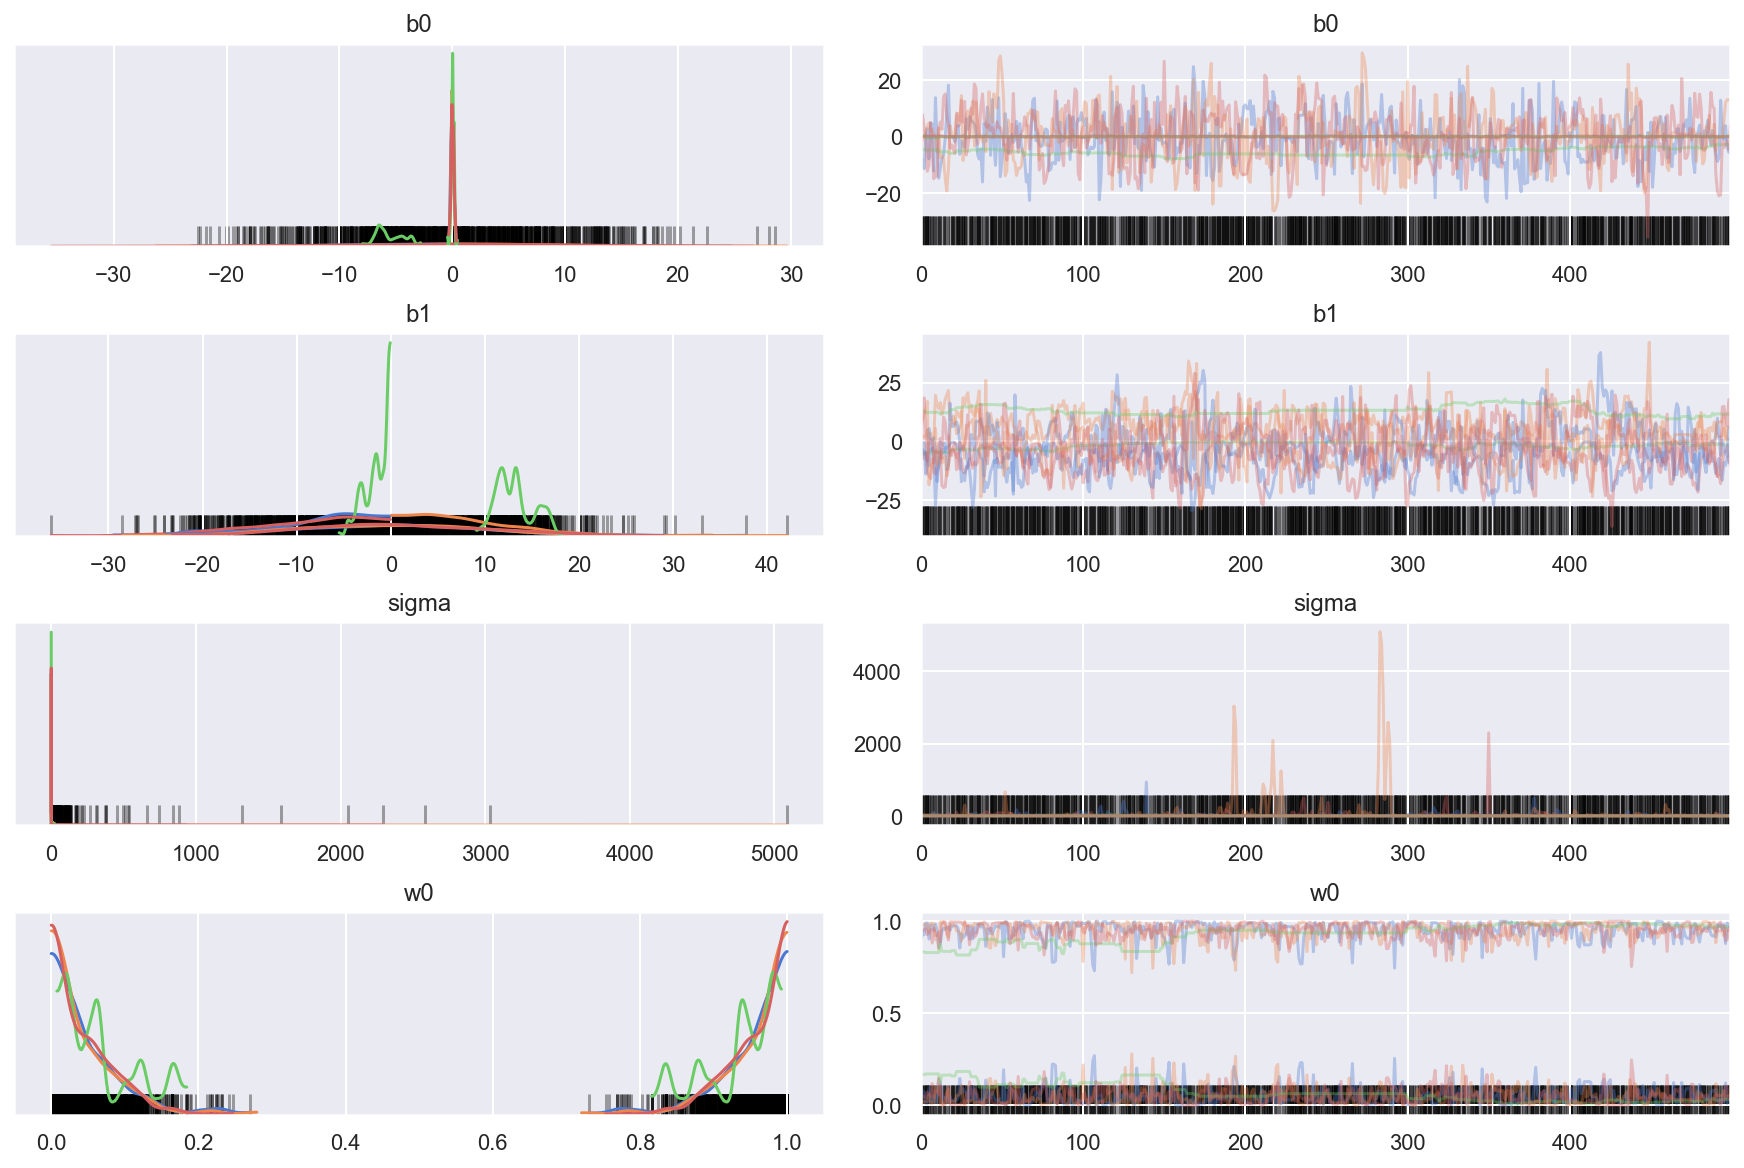

In [107]:
rvs = ['b0', 'b1', 'sigma', 'w0']
_ = az.plot_trace(trc_mix_marg, var_names=rvs, combined=False, compact=True)

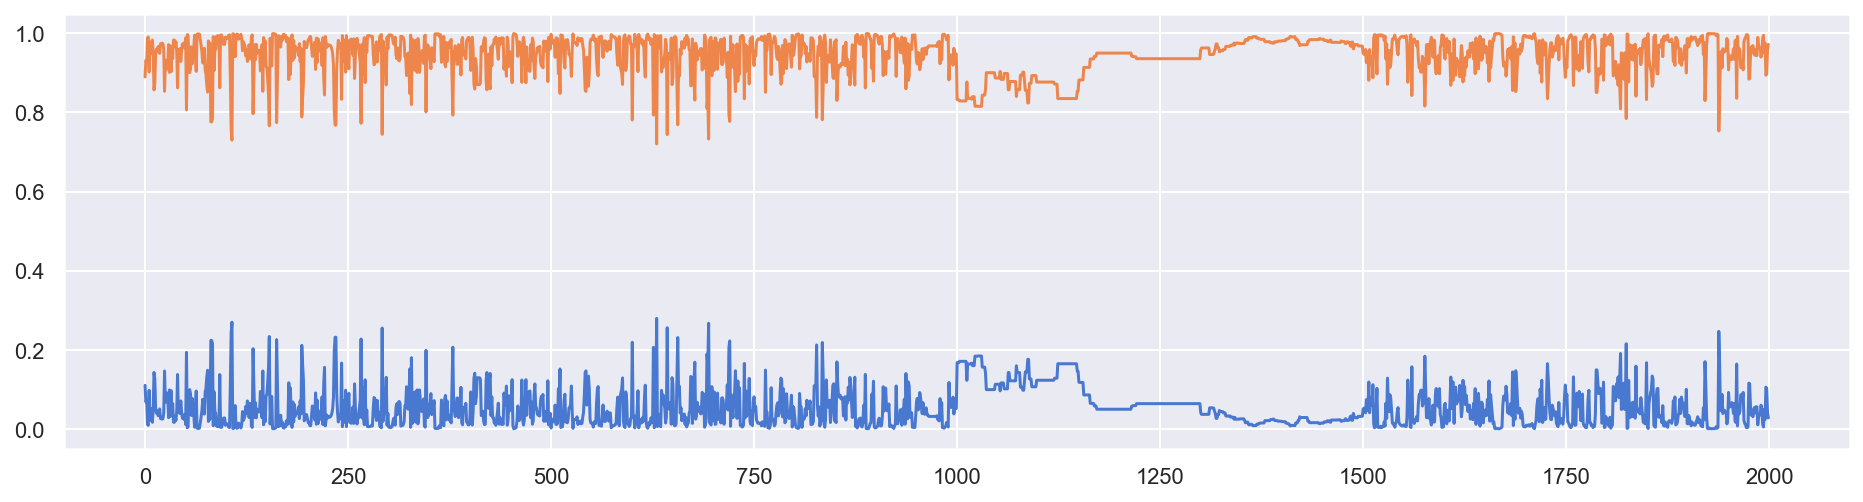

In [108]:
_ = plt.plot(trc_mix_marg.get_values('w0'))

##### Simple trace summary inc rhat

In [109]:
pm.summary(trc_mix_marg, var_names=rvs)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
b0__0,-1.473588,8.189361,0.351797,-16.569066,16.161145,65.167683,1.059146
b0__1,0.017824,0.126356,0.005579,-0.228409,0.255564,358.987550,1.008519
b1__0,-2.758850,8.524740,0.717770,-21.915974,13.983529,3.168055,1.755235
b1__1,3.276083,10.270943,0.662293,-17.535291,17.895849,6.465061,1.260539
sigma__0,39.028136,232.683433,11.548016,0.086880,94.119987,358.639152,1.012435
sigma__1,0.533842,0.101983,0.006186,0.362972,0.726675,57.672512,1.002545
w0__0,0.053967,0.048134,0.002892,0.000344,0.159929,36.123326,1.025149
w0__1,0.946033,0.048134,0.002892,0.840071,0.999656,36.123326,1.025149


##### View posterior distributions of each Normal

In [90]:
# df_trc_mix = pm.trace_to_dataframe(trc_mix)
# gd = sns.jointplot(x='mu__0', y='mu__1', data=df_trc_mix, height=6, 
#                    marginal_kws={'kde':True, 'kde_kws':{'cut':1}},
#                    joint_kws={'alpha':0.2})
# gd.plot_joint(sns.kdeplot, zorder=0, cmap="Blues", n_levels=12)
# _ = gd.fig.suptitle('Posterior joint distribution (mu0, mu1)', y=1.02)

## 3.3 Declare Outliers

### 3.3.1 View ranges for inliers / outlier predictions

In [28]:
# WIP

---

# 4. Gaussian Mixture Model: Non-Marginalized

## 4.1 Specify Model

Blurb WIP

\begin{align}
\mu_{k} &\sim \mathcal{N}(0, 1)\\
\sigma_{k} &\sim \text{HalfCauchy}(10)\\
\\
\vec{\alpha} &\sim [1]^K\\
\vec{w} &\sim \text{Dir}(\vec{\alpha})\\
\eta | \vec{w} &\sim Cat(\vec{w})\\
\\
\hat{y} | \eta &\sim \mathcal{N}(\mu_{k}, \sigma_{k})
\end{align}

... where:
+ $k \in K$ total Gaussian mixtures (here $K = 2$: one for inliers, one for outliers)
+ $\eta$ is the latent classification label of $k \in K$


```python
# + $\beta$ = $\{1, \beta_{j \in X_{j}}\}$  <-- linear coefs in $X_{j}$, in this case `1 + x`
# + $\sigma$ = measurement error on the y axis <-- in this case we set this to the measured error `sigma_y`

# Note: the dataset also has `sigma_x` and `rho_xy` available, but for this exercise, I've chosen to only use `sigma_y`
```

In [84]:
eta = ['inlier', 'outlier']
K = len(eta)

with pm.Model() as mdl_mix_marg:
    
    # input data as Theano shared vars
    tsv_x = pm.Data('tsv_x', np.concatenate(
                                (dfhoggs['x'].values.reshape(-1, 1), 
                                 np.zeros((len(a), 1))), axis=1))     # (n, K)
    tsv_y = pm.Data('tsv_y', dfhoggs['y'])                            # (n, )
    
    # priors (L2 ridge reg) for inliers
    b0 = pm.Normal('b0', mu=0, sigma=10, shape=(K,), 
                   testval=([pm.floatX(tsv_y.eval().mean())]*K))             # (K, )
    b1 = pm.Normal('b1', mu=0, sigma=10, shape=(K,))                  # (K, ) 
        
    # noise
    sigma = pm.HalfCauchy('sigma', beta=10, shape=(K,))               # (K, )
    
    mu = b0 + b1 * tsv_x                                              # (n, K)

    # break symmetry
    #pm.Potential('order', tt.switch(mu[1] - mu[0] < 0, -1e15, 0)) 

    # weakly informative prior on mixture weights
    w0 = pm.Dirichlet('w0', a=np.ones(K), testval=np.ones(K)/K)       # (K, )

    likelihood = pm.NormalMixture('likelihood', w=w0, mu=mu, 
                                  sigma=sigma, observed=tsv_y)


## 3.2 Fit Model

### 3.2.1 Sample Posterior

In [85]:
with mdl_mix_marg:
    trc_mix = pm.sample(tune=500, draws=500, chains=3, cores=3, 
                    init='jitter+adapt_diag', progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [w0, sigma, b1, b0]
Sampling 3 chains: 100%|██████████| 3000/3000 [00:18<00:00, 166.66draws/s]
The acceptance probability does not match the target. It is 0.8975095247549469, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


### 3.2.2 View Diagnostics

##### Traceplot

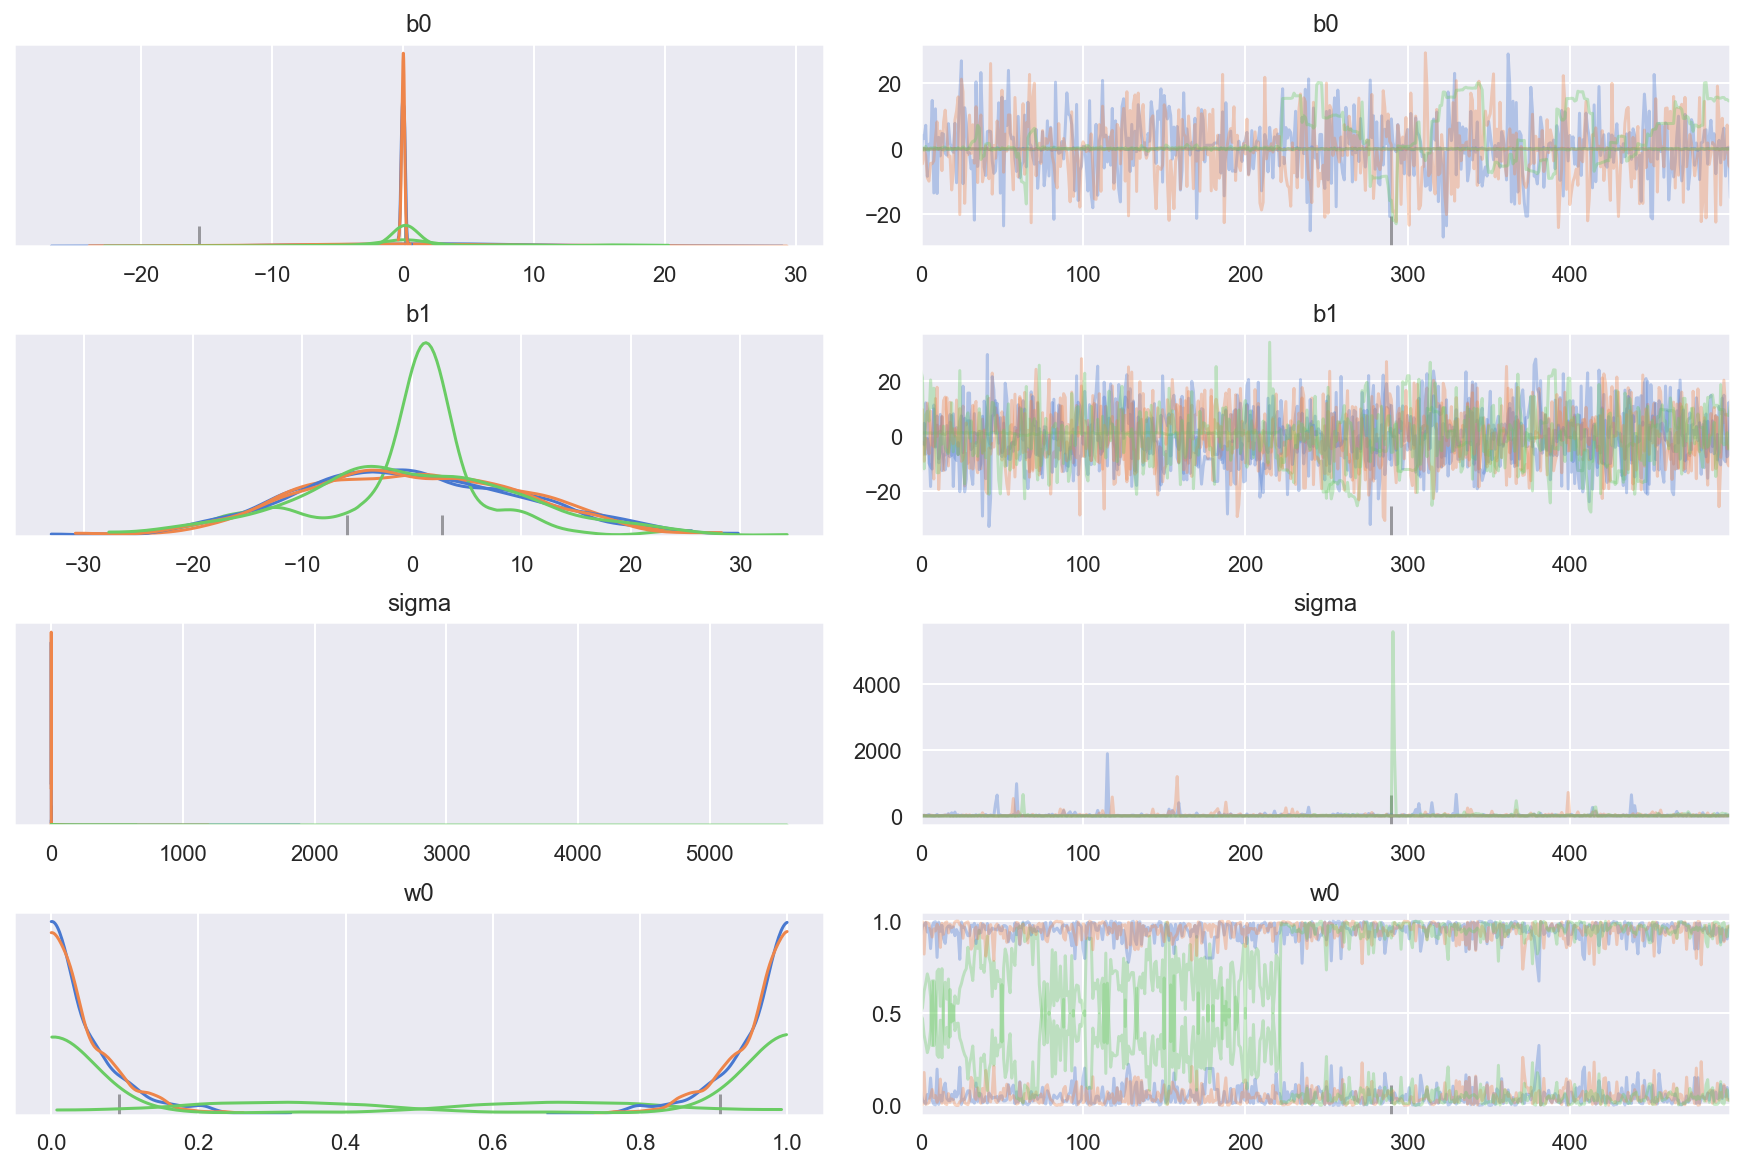

In [92]:
rvs = ['b0', 'b1', 'sigma', 'w0']
_ = az.plot_trace(trc_mix, var_names=rvs, combined=False, compact=True)

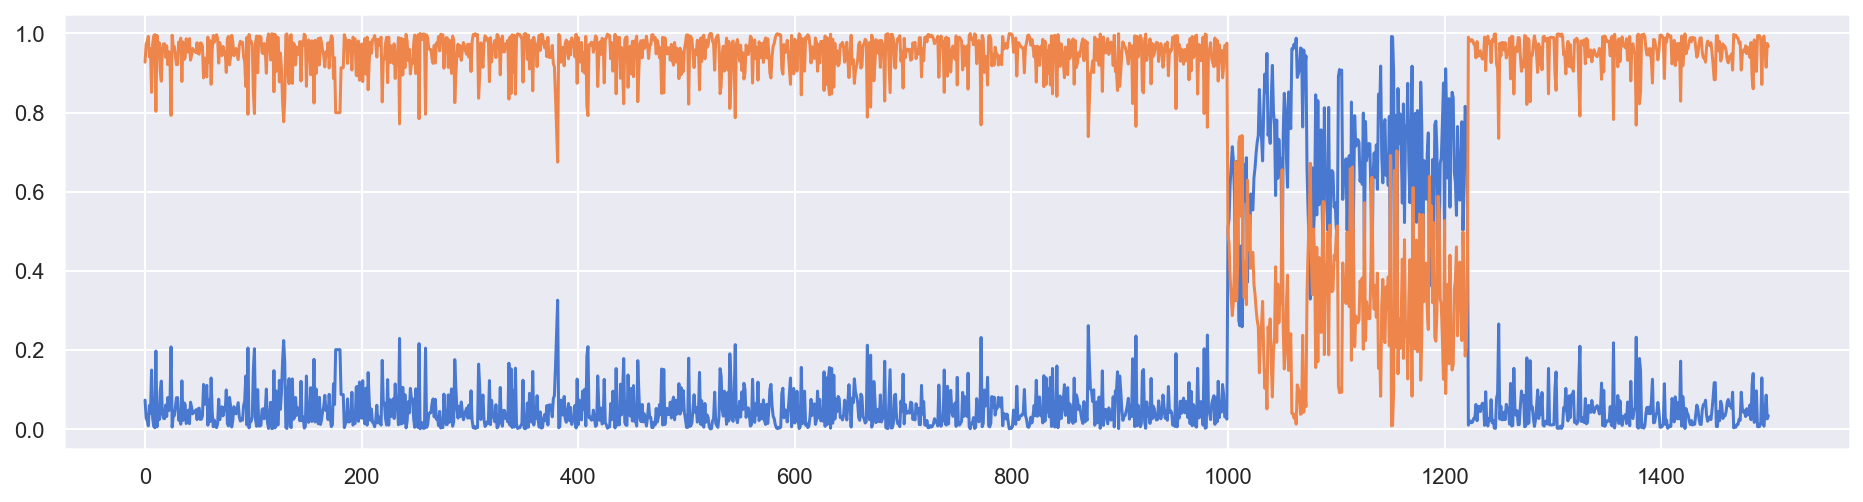

In [95]:
_ = plt.plot(trc_mix.get_values('w0'))

##### Simple trace summary inc rhat

In [88]:
pm.summary(trc_mix, var_names=rvs)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
b0__0,1.142021,9.040042,0.435577,-17.241876,19.263638,219.677645,1.018143
b0__1,0.027976,0.799641,0.028752,-0.352055,0.454394,461.846931,1.000755
b1__0,-0.437962,9.208927,0.404054,-18.596495,17.775913,316.913283,1.000870
b1__1,-0.180933,10.205704,0.239342,-19.638577,19.892766,1628.924065,0.999122
sigma__0,30.270356,172.710711,5.411082,0.008801,88.082094,1025.835961,0.999123
sigma__1,1.204189,17.117484,0.535940,0.310446,0.913152,819.527616,1.001313
w0__0,0.142946,0.236255,0.022137,0.000082,0.763376,5.949395,1.282435
w0__1,0.857054,0.236255,0.022137,0.236624,0.999918,5.949395,1.282435


In [ ]:
## 3.1 Specify Model

Blurb WIP

\begin{align}
\mu_{k} &\sim \mathcal{N}(0, 1)\\
\sigma_{k} &\sim \text{HalfCauchy}(10)\\
\\
\vec{\alpha} &\sim [1]^K\\
\vec{w} &\sim \text{Dir}(\vec{\alpha})\\
\eta | \vec{w} &\sim Cat(\vec{w})\\
\\
\hat{y} | \eta &\sim \mathcal{N}(\mu_{k}, \sigma_{k})
\end{align}

... where:
+ $k \in K$ total Gaussian mixtures (here $K = 2$: one for inliers, one for outliers)
+ $\eta$ is the latent classification label of $k \in K$


```python
# + $\beta$ = $\{1, \beta_{j \in X_{j}}\}$  <-- linear coefs in $X_{j}$, in this case `1 + x`
# + $\sigma$ = measurement error on the y axis <-- in this case we set this to the measured error `sigma_y`

# Note: the dataset also has `sigma_x` and `rho_xy` available, but for this exercise, I've chosen to only use `sigma_y`
```

eta = ['inlier', 'outlier']
K = len(eta)

with pm.Model() as mdl_mix_marg:
    
    # input data as Theano shared vars
    tsv_x = pm.Data('tsv_x', np.concatenate(
                                (dfhoggs['x'].values.reshape(-1, 1), 
                                 np.zeros((len(a), 1))), axis=1))     # (n, K)
    tsv_y = pm.Data('tsv_y', dfhoggs['y'])                            # (n, )
    
    # priors (L2 ridge reg) for inliers
    b0 = pm.Normal('b0', mu=0, sigma=10, shape=(K,), 
                   testval=([pm.floatX(tsv_y.eval().mean())]*K))             # (K, )
    b1 = pm.Normal('b1', mu=0, sigma=10, shape=(K,))                  # (K, ) 
        
    # noise
    sigma = pm.HalfCauchy('sigma', beta=10, shape=(K,))               # (K, )
    
    mu = b0 + b1 * tsv_x                                              # (n, K)

    # break symmetry
    #pm.Potential('order', tt.switch(mu[1] - mu[0] < 0, -1e15, 0)) 

    # weakly informative prior on mixture weights
    w0 = pm.Dirichlet('w0', a=np.ones(K), testval=np.ones(K)/K)       # (K, )

    likelihood = pm.NormalMixture('likelihood', w=w0, mu=mu, 
                                  sigma=sigma, observed=tsv_y)


## 3.2 Fit Model

### 3.2.1 Sample Posterior

with mdl_mix_marg:
    trc_mix = pm.sample(tune=500, draws=500, chains=3, cores=3, 
                    init='jitter+adapt_diag', progressbar=True)

### 3.2.2 View Diagnostics

##### Traceplot

rvs = ['b0', 'b1', 'sigma', 'w0']
_ = az.plot_trace(trc_mix, var_names=rvs, combined=False, compact=True)

_ = plt.plot(trc_mix.get_values('w0'))

##### Simple trace summary inc rhat

pm.summary(trc_mix, var_names=rvs)

# 5. Posterior Prediction Plot

In [91]:
# gd = sns.FacetGrid(dfhoggs, height=10, palette='Set1', legend_out=False)

# inlier_mean = lambda x, s: s['mu'][0] * x ** 0
# outlier_mean = lambda x, s: s['mu'][1] * x ** 0

# pm.plot_posterior_predictive_glm(trc_mix, lm=inlier_mean,
#             eval=np.linspace(-3, 3, 10), samples=400, 
#             color='#357EC7', alpha=.2, zorder=1)

# pm.plot_posterior_predictive_glm(trc_mix, lm=outlier_mean,
#             eval=np.linspace(-3, 3, 10), samples=400, 
#             color='#CC3333', alpha=.2, zorder=2)

# _ = plt.title(None)

# line_legend = plt.legend(
#     [Line2D([0], [0], color='#357EC7'), Line2D([0], [0], color='#CC4444')],
#     ['Mixture: Inliers', 'Mixture: Outliers'], loc='lower right', 
#     title='Posterior Predictive')
# _ = gd.fig.get_axes()[0].add_artist(line_legend)

# # plot points
# _ = gd.map(plt.errorbar, 'x', 'y', 'sigma_y', 'sigma_x', marker="o", 
#           ls='', markeredgecolor='w', markersize=10, zorder=5).add_legend()
# # _ = gd.ax.legend(loc='upper left', title='Outlier Classification')

# ## create xlims ylims for plotting
# x_ptp = np.ptp(dfhoggs['x'].values)/3.3
# y_ptp = np.ptp(dfhoggs['y'].values)/3.3
# xlims = (dfhoggs['x'].min()-x_ptp, dfhoggs['x'].max()+x_ptp)
# ylims = (dfhoggs['y'].min()-y_ptp, dfhoggs['y'].max()+y_ptp)
# _ = gd.axes.ravel()[0].set(ylim=ylims, xlim=xlims)
# _ = gd.fig.suptitle(('Standardized datapoints in Hogg 2010 dataset, showing ' + 
#         'posterior predictive fit for a mixture of 2 normal likelihoods'), y=1.04, fontsize=16)

---

---

# Notes

##### Online halp

https://gist.github.com/junpenglao/4d65d1a9bf80e8d371446fadda9deb7a

https://discourse.pymc.io/t/gaussian-mixture-of-regression/537/2

https://gist.github.com/junpenglao/1907bf019906c125f63126ec4bf23880

https://discourse.pymc.io/t/how-do-we-get-mixture-variables-and-components-from-traces/1038/11

##### Dirichlet reminder

In [ ]:
# rvs_dir = pm.Dirichlet.dist(a=np.array([1, 1])).random(size=1000)
# df_rvs_dir = pd.DataFrame(rvs_dir, columns=['x', 'y'])
# gd = sns.jointplot(x='x', y='y', data=df_rvs_dir, kind='kde')

##### Version history (by contribution to pymc3 examples docs):

version | date | author | changes
:--- | :--- | :--- | :---
1.0 | 2019-11-03 | [jonsedar](https://github.com/jonsedar) | Create and publish